08/16/2020

# 2BR3_rna_brainmap_m1_comp (used this data for fig2b)


similar to brain span comparison but use the 

https://celltypes.brain-map.org/rnaseq/human_ctx_smart-seq

## Human Multiple Cortical Areas SMART-seq
This data set includes single-nucleus transcriptomes from 49,495 nuclei across multiple human cortical areas. Individual layers of cortex were dissected from tissues covering the middle temporal gyrus (MTG), anterior cingulate cortex (ACC; also known as the ventral division of medial prefrontal cortex, A24), primary visual cortex (V1C), primary motor cortex (M1C), primary somatosensory cortex (S1C) and primary auditory cortex (A1C) derived from human brain. Nuclei were dissociated and sorted using the neuronal marker NeuN. Nuclei were sampled from post-mortem and neurosurgical (MTG only) donor brains and expression was profiled with SMART-Seq v4 RNA-sequencing.


figure out 
- A. what cell types the tissues are like
- B. Focus on the egenes for each dz and see which cell types these egenes are turned on in


Note on m1 data set (motor cortex data)

- (NOT USED) the 2020 10X M1 data: Transcriptomic characterization of cell types in human M1 using droplet-based single nucleus RNA sequencing


https://knowledge.brain-map.org/data/8GU8FPSNLBUBCJWQDZ5/summary


PROJECT DESCRIPTION
To investigate the cellular diversity of the human cortex, we used 10x Genomics Chromium single nucleus RNA-sequencing technology to perform a survey of the cell types in human primary motor cortex. Nuclei were sampled from 2 postmortem donor brains and dissociated nuclei were labeled using an antibody against the neuronal marker NeuN to facilitate enrichment for neurons using fluorescence-activated cell sorting (FACS). Profiled nuclei included approximately 90% neurons and 10% glia.



In [1]:
R.version

               _                           
platform       x86_64-apple-darwin13.4.0   
arch           x86_64                      
os             darwin13.4.0                
system         x86_64, darwin13.4.0        
status                                     
major          3                           
minor          6.1                         
year           2019                        
month          07                          
day            05                          
svn rev        76782                       
language       R                           
version.string R version 3.6.1 (2019-07-05)
nickname       Action of the Toes          

In [86]:
library(pheatmap)  
library(tidyverse)
library(ggfortify)
library(RColorBrewer)
library(viridis)
library(reshape2)
library(Rtsne)
# library(umap)
library( org.Hs.eg.db ) 
library(AnnotationDbi) 
library(Biobase)
library(limma)
library(tximport)

library(stringr)

library(Rtsne)
library(caret)  
library(clusterProfiler)
library(pheatmap)
library(ReactomePA)
library(annotate)
library(seqinr)
# library(qlcMatrix)


In [91]:
save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}


# rna_df is samples x genes and removed low variances genes
remove_lowvar_genes = function(rna_df){
    nzv_cols <- nearZeroVar(rna_df)
    print(dim(rna_df))
    if(length(nzv_cols) > 0) rna_df <- rna_df[, -nzv_cols]
    print(dim(rna_df))
    return(rna_df)

}




In [4]:
save_prefix = '../data/processed/fig1/rna_10xm1/'

# 1. Read in RNA file 

In [5]:
rna_tpm_file_tissue = '../data/interim/rna/tissue_tpm_sym.csv'
rna_df_tissue = read.csv(rna_tpm_file_tissue, row.names=1,stringsAsFactors=F,check.names = FALSE)
# DO AFTER ADDING 293T
# rna_df_tissue_log = log2(rna_df_tissue+1e-2)
# rna_df_tissue_log_bin = rna_df_tissue_log
# rna_df_tissue_log_bin[rna_df_tissue_log<0] = 0
# rna_df_tissue_log_bin[rna_df_tissue_log>0] = 1

# rna_df_tissue_norm = as.data.frame(scale(rna_df_tissue_log, center = TRUE, scale = TRUE))


In [6]:
colnames(rna_df_tissue)

[1] "Astrocytes" "SL_D0"      "SL_D2"      "SLC_D0"     "SLC_D2"    
[6] "H9_D0"      "H9_D2"      "H9_D10"     "H9_D28"

In [7]:
dim(rna_df_tissue)
head(rna_df_tissue)

[1] 23686     9

,Astrocytes,SL_D0,SL_D2,SLC_D0,SLC_D2,H9_D0,H9_D2,H9_D10,H9_D28
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,18.660,7.230,4.01666667,6.993333333,3.616666667,12.485,7.470000000,5.27,5.475
A1BG-AS1,0.430,2.040,2.71000000,1.656666667,2.700000000,0.915,2.770000000,3.30,3.710
A1CF,0.010,0.015,0.02666667,0.010000000,0.003333333,0.000,0.006666667,0.11,0.160
A2M,50.670,0.055,2.48333333,0.156666667,6.546666667,0.020,15.666666667,3.74,2.970
A2M-AS1,0.070,2.580,1.67000000,0.996666667,2.160000000,0.285,0.680000000,5.34,7.985
A2ML1,0.055,0.115,0.01333333,0.006666667,0.000000000,5.020,1.066666667,0.06,0.000


In [8]:
# pca_rna <- prcomp(rna_df_tissue_t, scale. = TRUE)


In [9]:
# summary(pca_rna)

In [10]:
# # autoplot(pca_rna)
# ggplot(cbind(pca_rna$x, data.frame(tissue=rownames(rna_df_tissue_t))), aes(x=PC1, y=PC2, color=tissue,label=tissue))+
#     geom_point()+
#   geom_text(size=2,position=position_jitter(width=5,height=5))

# 2  Get 293T data


In [11]:
# print(keytypes(org.Hs.eg.db))
enst_sym_df = read.csv('../data/external/enst_sym_df.csv',stringsAsFactor=F)
head(enst_sym_df)

,X,query,X_id,X_score,name,symbol,taxid,entrezgene,notfound
,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>,<chr>
1,0,ENST00000631435,ENSG00000282253,23.12972,T cell receptor beta diversity 1,TRBD1,9606,NA,
2,1,ENST00000434970,ENSG00000237235,23.12966,T cell receptor delta diversity 2,TRDD2,9606,NA,
3,2,ENST00000448914,ENSG00000228985,23.12934,T cell receptor delta diversity 3,TRDD3,9606,NA,
4,3,ENST00000415118,ENSG00000223997,23.12972,T cell receptor delta diversity 1,TRDD1,9606,NA,
5,4,ENST00000632684,ENSG00000282431,23.12972,T cell receptor beta diversity 1,TRBD1,9606,NA,
6,5,ENST00000604446,ENSG00000270824,23.12644,immunoglobulin heavy diversity 5/OR15-5B (non-functional),IGHD5OR15-5B,9606,NA,


In [12]:
# get_symbol <- function (enst_id) {
#   return(tryCatch(bitr(enst_id, fromType="ENSEMBLTRANS", toType="SYMBOL", OrgDb="org.Hs.eg.db")$SYMBOL,
#                   error=function(e) NULL))
# }
get_hek = function (hek_file){
    hek_df = read.table(hek_file,header=T, stringsAsFactor=F)
    dim(hek_df)
    hek_df = separate(hek_df, target_id, c("enst", "suffix") )#%>%
    #     filter(tpm>1)
    # hek_df$enst = sapply(hek_df$target_id, function(x) str_split(x, '[.]')[[1]][1])
    # dim(hek_df)
    enst_ids_all = hek_df$enst
    # head(hek_df)
#     enst_sym_df = bitr(enst_ids_all, fromType="ENSEMBLTRANS", toType="SYMBOL", OrgDb="org.Hs.eg.db")
#     dim(enst_sym_df)
#     head(enst_sym_df)
    hek_df = inner_join(hek_df, enst_sym_df, by=c('enst'='query'))
    dim(hek_df)
    hek_df = hek_df%>%
        group_by(symbol)%>%
        summarise(tpm = sum(tpm))
    return(hek_df)
}
                  

In [13]:
list.files('../data/raw/rna/HEK293T/')

[1] "SRR3997504.tsv" "SRR3997505.tsv" "SRR3997506.tsv" "SRR3997507.tsv"

In [14]:
hek_df_all = data.frame(SYMBOL=c(''))
for (file in list.files('../data/raw/rna/HEK293T')){
    hek_file = paste0('../data/raw/rna/HEK293T/',file)
    print(hek_file)
    sample = strsplit(file,'[.]')[[1]][1]
    hek_df = get_hek(hek_file)
    colnames(hek_df) = c('SYMBOL',sample)
    hek_df_all = full_join(hek_df_all, hek_df, by='SYMBOL')
    print(dim(hek_df_all))
}

# first line is blank
hek_df_all = hek_df_all[2:dim(hek_df_all)[1],]
hek_df_all[is.na(hek_df_all)] = 0

[1] "../data/raw/rna/HEK293T/SRR3997504.tsv"


Warning message:
“Column `SYMBOL` joining factor and character vector, coercing into character vector”


[1] 36314     2
[1] "../data/raw/rna/HEK293T/SRR3997505.tsv"
[1] 36314     3
[1] "../data/raw/rna/HEK293T/SRR3997506.tsv"
[1] 36314     4
[1] "../data/raw/rna/HEK293T/SRR3997507.tsv"
[1] 36314     5


In [15]:
rownames(hek_df_all) = NULL

In [16]:
hek_df_all = hek_df_all%>%
    column_to_rownames('SYMBOL')

In [17]:
dim(hek_df_all)
head(hek_df_all)

[1] 36313     4

,SRR3997504,SRR3997505,SRR3997506,SRR3997507
,<dbl>,<dbl>,<dbl>,<dbl>
5S_rRNA,0.00000000,0.00000000,3.7692500,0.00000000
A1BG,21.44756600,23.60236470,24.0277990,22.29540900
A1CF,0.08787141,0.07170218,0.0255588,0.14311757
A2M,1.16461110,1.38938680,1.2532203,1.22724925
A2ML1,0.33645390,0.10741280,0.2931527,0.08382345
A2MP1,0.45772630,0.46116600,0.4138344,0.59480400


In [18]:
hek_data = data.frame(HEK293T=rowMeans(hek_df_all))


In [19]:
rna_df_tissue_new = left_join(rownames_to_column(rna_df_tissue),rownames_to_column(hek_data), by='rowname')
rna_df_tissue_new[is.na(rna_df_tissue_new)] =0 
rna_df_tissue_new = rna_df_tissue_new %>% column_to_rownames('rowname')


In [20]:
colSums(rna_df_tissue_new)

Astrocytes      SL_D0      SL_D2     SLC_D0     SLC_D2      H9_D0      H9_D2 
  822514.9  1000000.4   999999.8   999999.7   999999.7  1000000.4  1000000.1 
    H9_D10     H9_D28    HEK293T 
  997291.4   997350.6   836091.1

In [21]:
# DO AFTER ADDING 293T
rna_df_tissue_log = log2(rna_df_tissue_new+1)

# rna_df_tissue_log_bin = rna_df_tissue_log
# rna_df_tissue_log_bin[rna_df_tissue_log<0] = 0
# rna_df_tissue_log_bin[rna_df_tissue_log>0] = 1

rna_df_tissue_log_norm = as.data.frame(scale(rna_df_tissue_log, center = TRUE, scale = TRUE))


# brainspan_expr_gene_t = cbind(t(brainspan_expr_gene), brainspan_sample_meta_structure)
rna_df_tissue_new_t = t(rna_df_tissue_new)
nzv_cols <- nearZeroVar(rna_df_tissue_new_t)
dim(rna_df_tissue_new_t)
if(length(nzv_cols) > 0) rna_df_tissue_new_t <- rna_df_tissue_new_t[, -nzv_cols]
dim(rna_df_tissue_new_t)


[1]    10 23686

[1]    10 21146

In [22]:
dim(rna_df_tissue_log_norm)

[1] 23686    10

In [23]:
write.csv(hek_df_all, '../data/raw/rna/HEK293T_tpm_sym.csv')

write.csv(rna_df_tissue_new, '../data/interim/rna/tissue_tpm_sym_wHEK.csv')
write.csv(rna_df_tissue_log, '../data/interim/rna/tissue_tpm_log_sym_wHEK.csv')
write.csv(rna_df_tissue_log_norm, '../data/interim/rna/tissue_tpm_lognorm_sym_wHEK.csv')

In [24]:
metadata_rna = data.frame(cluster_label = colnames(rna_df_tissue_new))
rownames(metadata_rna) = metadata_rna$cluster_label
metadata_rna$class_label = sapply(colnames(rna_df_tissue_new),function(x) strsplit(x,'_')[[1]][1])
metadata_rna$subclass_label = 'RNA'#metadata_rna$cluster_label
# metadata_rna$region_label = 'RNA'#metadata_rna$cluster_label
# metadata_rna$cortical_layer_label = 'RNA'
metadata_rna

,cluster_label,class_label,subclass_label
,<fct>,<chr>,<chr>
Astrocytes,Astrocytes,Astrocytes,RNA
SL_D0,SL_D0,SL,RNA
SL_D2,SL_D2,SL,RNA
SLC_D0,SLC_D0,SLC,RNA
SLC_D2,SLC_D2,SLC,RNA
H9_D0,H9_D0,H9,RNA
H9_D2,H9_D2,H9,RNA
H9_D10,H9_D10,H9,RNA
H9_D28,H9_D28,H9,RNA


# 3. get brainmap data

In [25]:
brainmap_dir = '../data/external/brainmap_cortex_smartseq/'
list.files(brainmap_dir)

[1] "dend.json"                                                
[2] "matrix.csv"                                               
[3] "medians.csv"                                              
[4] "metadata.csv"                                             
[5] "readme_human_ctx.txt"                                     
[6] "sample-exp_component_mapping_human_smart-seq_oct_2019.zip"
[7] "taxonomy.zip"                                             
[8] "trimmed_means.csv"

In [309]:
# brainmap_expr_df = read.csv(paste0(brainmap_dir,'trimmed_means.csv'),row.names=1)
# dim(brainmap_expr_df)
# head(brainmap_expr_df)
# 50281 genes with
# 121 types

# 3A read metadata

In [27]:
metadata_cell_df = read.csv(paste0(brainmap_dir,'metadata.csv'))

In [28]:
head(metadata_cell_df)
colnames(metadata_cell_df)

,sample_name,exp_component_name,specimen_type,cluster_color,cluster_order,cluster_label,class_color,class_order,class_label,subclass_color,⋯,cell_type_alt_alias_order,cell_type_alt_alias_label,cell_type_designation_color,cell_type_designation_order,cell_type_designation_label,external_donor_name_color,external_donor_name_order,external_donor_name_label,outlier_call,outlier_type
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,⋯,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
1,F2S4_160113_027_A01,LS-15005h_S01_E1-50,nucleus,,NA,,,NA,,,⋯,NA,,,NA,,#3DCC3D,2,H200.1025,True,Outlier L1-3 SST OR2AD1P
2,F2S4_160113_027_B01,LS-15005h_S02_E1-50,nucleus,#E170FE,32,Inh L2-5 VIP TOX2,#0066FF,4,GABAergic,#996517,⋯,32,,#E170FE,32,Neuron 032,#3DCC3D,2,H200.1025,False,
3,F2S4_160113_027_C01,LS-15005h_S03_E1-50,nucleus,#8E5864,2,Inh L1 LAMP5 GGT8P,#0066FF,4,GABAergic,#FF7373,⋯,2,,#8E5864,2,Neuron 002,#3DCC3D,2,H200.1025,False,
4,F2S4_160113_027_D01,LS-15005h_S04_E1-50,nucleus,#8B5862,1,Inh L1 LAMP5 NDNF,#0066FF,4,GABAergic,#FF7373,⋯,1,,#8B5862,1,Neuron 001,#3DCC3D,2,H200.1025,False,
5,F2S4_160113_027_E01,LS-15005h_S05_E1-50,nucleus,#CF6EC9,34,Inh L1-3 VIP ZNF322P1,#0066FF,4,GABAergic,#996517,⋯,34,,#CF6EC9,34,Neuron 034,#3DCC3D,2,H200.1025,False,
6,F2S4_160113_027_F01,LS-15005h_S06_E1-50,nucleus,#E693CE,35,Inh L3 VIP CBLN1,#0066FF,4,GABAergic,#996517,⋯,35,,#E693CE,35,Neuron 035,#3DCC3D,2,H200.1025,False,


[1] "sample_name"                 "exp_component_name"         
 [3] "specimen_type"               "cluster_color"              
 [5] "cluster_order"               "cluster_label"              
 [7] "class_color"                 "class_order"                
 [9] "class_label"                 "subclass_color"             
[11] "subclass_order"              "subclass_label"             
[13] "full_genotype_color"         "full_genotype_order"        
[15] "full_genotype_label"         "donor_sex_color"            
[17] "donor_sex_order"             "donor_sex_label"            
[19] "region_color"                "region_order"               
[21] "region_label"                "cortical_layer_color"       
[23] "cortical_layer_order"        "cortical_layer_label"       
[25] "cell_type_accession_color"   "cell_type_accession_order"  
[27] "cell_type_accession_label"   "cell_type_alias_color"      
[29] "cell_type_order"             "cell_type_alias_label"      
[31] "cell_type_alt_alias_color"   "cell_type_alt_alias_order"  
[33] "cell_type_alt_alias_label"   "cell_type_designation_color"
[35] "cell_type_designation_order" "cell_type_designation_label"
[37] "external_donor_name_color"   "external_donor_name_order"  
[39] "external_donor_name_label"   "outlier_call"               
[41] "outlier_type"

In [1]:
metadata_cell_df%>%
    dplyr::select(cluster_label, class_label,subclass_label)%>%#,region_label,cortical_layer_label)%>%
    mutate(cluster_id = str_replace_all(cluster_label, "[ .-]", "."))%>%
    filter(cluster_label!='')%>%
    distinct()

ERROR: Error in metadata_cell_df %>% dplyr::select(cluster_label, class_label, : could not find function "%>%"


In [29]:
metadata = metadata_cell_df%>%
    dplyr::select(cluster_label, class_label,subclass_label)%>%#,region_label,cortical_layer_label)%>%
    mutate(cluster_id = str_replace_all(cluster_label, "[ .-]", "."))%>%
    filter(cluster_label!='')%>%
    distinct()%>%
#     group_by(cluster_id)%>%
    
    column_to_rownames('cluster_id')
head(metadata)
dim(metadata)

,cluster_label,class_label,subclass_label
,<fct>,<fct>,<fct>
Inh.L2.5.VIP.TOX2,Inh L2-5 VIP TOX2,GABAergic,VIP
Inh.L1.LAMP5.GGT8P,Inh L1 LAMP5 GGT8P,GABAergic,LAMP5
Inh.L1.LAMP5.NDNF,Inh L1 LAMP5 NDNF,GABAergic,LAMP5
Inh.L1.3.VIP.ZNF322P1,Inh L1-3 VIP ZNF322P1,GABAergic,VIP
Inh.L3.VIP.CBLN1,Inh L3 VIP CBLN1,GABAergic,VIP
Inh.L1.4.LAMP5.DUSP4,Inh L1-4 LAMP5 DUSP4,GABAergic,LAMP5


[1] 120   3

In [30]:
metadata%>%
#     group_by(cortical_layer_label)%>%tally()
    group_by(class_label)%>%tally()

class_label,n
<fct>,<int>
GABAergic,54
Glutamatergic,56
Non-neuronal,10


In [310]:
# metadata_all = rbind(metadata_rna,metadata)
# metadata_all

In [41]:
# length(colnames(brainmap_expr_df))
# sum(colnames(brainmap_expr_df) %in% rownames(metadata))

In [ ]:
brainmap_expr_df = brainmap_expr_df[,colnames(brainmap_expr_df) %in% rownames(metadata)]

removed a cell type

### get mean by region_label and cortical_layer_label

In [311]:
metadata_region = metadata_cell_df%>%
    group_by(region_label)%>%tally()%>%
    mutate(cluster_label=region_label)%>%
    mutate(class_label='SMARTseq')
metadata_region

region_label,n,cluster_label,class_label
<fct>,<int>,<fct>,<chr>
A1C,6703,A1C,SMARTseq
CgG,6279,CgG,SMARTseq
M1lm,3371,M1lm,SMARTseq
M1ul,2864,M1ul,SMARTseq
MTG,16155,MTG,SMARTseq
S1lm,2805,S1lm,SMARTseq
S1ul,3188,S1ul,SMARTseq
V1C,8052,V1C,SMARTseq


- A1C - primary auditory cortex
- CgG - cingulate gyrus
- M1lm -  lower limb regions of primary motor cortex.
- M1ul -  upper limb regions of primary motor cortex.
- MTG - Medial Temporal Gyrus
- S1lm -  lower limb regions of primary somatosensory cortex.
- S1ul-  upper limb regions of primary somatosensory cortex.
- V1C - primary visual cortex


In [33]:
brainmap_expr_df = read.csv(paste0(brainmap_dir,'matrix.csv'),row.names=1)

In [286]:
dim(brainmap_expr_df)

[1] 49417 50282

49417 samples (cells) by 50281 genes

In [35]:
sum(rownames(brainmap_expr_df)==metadata_cell_df$sample_name)# should be 49417

[1] 49417

In [82]:
brainmap_expr_df[1:5,50270:50282]

,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,ZZZ3,bA255A11.4,bA395L14.12,region_label
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
F2S4_160113_027_A01,0,0,0,282,0,0,0,41,448,0,0,1,MTG
F2S4_160113_027_B01,0,0,0,892,0,0,125,0,0,748,0,0,MTG
F2S4_160113_027_C01,0,0,0,0,1,0,161,0,102,0,0,0,MTG
F2S4_160113_027_D01,0,0,0,155,1,0,81,0,3,1,0,0,MTG
F2S4_160113_027_E01,0,0,0,14,1,0,490,0,4,33,0,0,MTG


In [83]:
brainmap_expr_df$region_label = metadata_cell_df$region_label
brainmap_expr_df_region =brainmap_expr_df %>%
    group_by(region_label)%>%
    summarise_all(median)%>%
    column_to_rownames('region_label')

In [285]:
dim(brainmap_expr_df_region)
pheatmap(log2(t(brainmap_expr_df_region[,marker_genes])))

[1]     8 50281

ERROR: Error in hclust(d, method = method): NA/NaN/Inf in foreign function call (arg 10)


In [ ]:
write.csv(brainmap_expr_df_region, paste0(save_prefix, 'brainmap_expr_df_region'))

In [50]:
brainmap_expr_df_region$region_label

[1] A1C  CgG  M1lm M1ul MTG  S1lm S1ul V1C 
Levels: A1C CgG M1lm M1ul MTG S1lm S1ul V1C

# 4. cbind our rnaseq data with this brain map data

In [290]:
genes_sel = rownames(rna_df_tissue_log)[rownames(rna_df_tissue_log) %in% colnames(brainmap_expr_df_region)]
length(genes_sel)


[1] 21655

In [291]:
rna_df_log_with_brainmap = cbind(rna_df_tissue_log[genes_sel,],t(brainmap_expr_df_region)[genes_sel,])
# colSums(rna_df_with_brainmap)
rna_df_lognorm_with_brainmap = as.data.frame(scale(rna_df_log_with_brainmap, center = TRUE, scale = TRUE))


# brainspan_expr_gene_t = cbind(t(brainspan_expr_gene), brainspan_sample_meta_structure)
rna_df_log_with_brainmap_t = t(rna_df_log_with_brainmap)
dim(rna_df_log_with_brainmap_t)
nzv_cols <- nearZeroVar(rna_df_log_with_brainmap_t)
if(length(nzv_cols) > 0) rna_df_log_with_brainmap_t <- rna_df_log_with_brainmap_t[, -nzv_cols]
dim(rna_df_log_with_brainmap_t)


[1]    18 21655

[1]    18 19628

In [292]:
pca_res <- prcomp(rna_df_log_with_brainmap_t, center=TRUE, scale = TRUE)


In [293]:
# per PC gene loadings
data.frame(pca_res$rotation)%>%
    rownames_to_column()%>%
    arrange(desc(PC1))%>%
    head()

,rowname,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TMEM59L,0.009216410,-0.003066467,0.002504472,-0.0007640796,-0.0013916627,0.0001772295,0.003924670,-0.0013343493,0.0028695792,0.0003736239,1.443120e-04,0.001273591,-0.0011425041,0.0013870903,-0.002398729,0.0009627965,0.007679660,0.0024996912
2,NUP210L,0.009201625,-0.002604793,0.003714853,-0.0014596621,-0.0007600651,-0.0003472219,0.002518483,-0.0005459578,-0.0020085085,0.0001290843,4.762245e-04,0.004585704,-0.0005586348,0.0002134649,0.006240194,0.0029846233,-0.003222996,0.0004806859
3,AAK1,0.009186595,-0.003412478,0.003410253,-0.0018289081,-0.0003177035,-0.0002906841,0.002296673,-0.0010437389,0.0021385868,0.0002818419,7.160555e-05,0.001849609,-0.0007736643,0.0041633571,0.002683970,-0.0038620392,-0.003016751,0.0007753882
4,SLC22A17,0.009184812,-0.003572770,0.002571596,-0.0011131121,-0.0013169281,-0.0004729612,0.003662854,-0.0012063759,0.0032940907,0.0004447377,1.946023e-04,-0.000618860,-0.0010094029,0.0021913993,-0.005028928,-0.0050492894,0.001135353,0.0049930430
5,LDLRAD4,0.009178944,-0.003208100,0.003120899,-0.0014368725,-0.0007100393,-0.0003480879,0.002656024,-0.0010813433,0.0006701092,0.0000617609,3.024744e-04,0.006275464,-0.0002553459,-0.0013072045,-0.002316235,-0.0059110121,-0.009414762,-0.0014425189
6,GARNL3,0.009173616,-0.003286451,0.003310580,-0.0015379004,-0.0007169505,-0.0002556208,0.002568764,-0.0007780330,0.0002508126,0.0001153577,1.815842e-04,0.002573683,-0.0009587667,0.0056412454,-0.004915333,-0.0025167168,-0.011087375,0.0050972330


In [294]:
# tail(pca_res$rotation)
head(pca_res$x)
dim(pca_res$x)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
Astrocytes,-31.42658,59.423689,-37.772819,39.152808,68.857625,17.84683,-56.616933,-0.4665647,8.192919,2.595076,-2.573222,0.1573060,-0.5180587,0.6294831,-0.16914758,-0.225011784,0.048407051,-6.714074e-14
SL_D0,-89.10364,-8.671197,-20.146035,-22.185763,-18.332209,-13.01389,-10.710652,53.0543290,4.385152,29.291878,4.369881,1.9028539,-33.1962029,-2.7462954,-0.07210858,-0.028658330,-0.039472879,8.645862e-15
SL_D2,-103.65158,-24.634137,-8.405119,-5.720043,12.485670,-54.91766,-1.876394,-38.9957009,-4.277398,25.025397,36.537612,-0.7956504,11.1889465,0.7050622,-0.01315450,0.012958756,-0.007478381,1.793010e-14
SLC_D0,-79.92195,-3.365850,-21.963005,-17.364026,-16.475513,-15.37088,-10.201699,46.7694129,2.353229,-9.823408,-6.606769,-2.7524127,44.1998192,3.5225871,-0.01285801,-0.125602082,0.040506810,7.500944e-15
SLC_D2,-99.71041,-22.303306,-10.072716,-6.108100,2.331175,-48.39788,-8.259249,-10.2498411,5.624309,-51.368106,-11.523746,1.4778450,-19.7639705,-0.6142828,0.10402913,-0.001909844,-0.001374799,1.148387e-15
H9_D0,-92.07821,5.430849,-26.597344,-55.086040,-20.868031,68.43016,-3.003795,-15.1626335,3.415539,-17.902739,31.035937,0.1229170,-2.2239350,0.2625045,-0.05295270,-0.021976019,0.008044779,1.757275e-15


[1] 18 18

In [295]:
# # metadata = data.frame(cell_type = rownames(pca_res$x), 
# #            cat = sapply(rownames(pca_res$x),function(x) strsplit(x, '[.]')[[1]][1]))
head(metadata_all)                                                        

,cluster_label,class_label,subclass_label
,<fct>,<chr>,<chr>
Astrocytes,Astrocytes,Astrocytes,RNA
SL_D0,SL_D0,SL,RNA
SL_D2,SL_D2,SL,RNA
SLC_D0,SLC_D0,SLC,RNA
SLC_D2,SLC_D2,SLC,RNA
H9_D0,H9_D0,H9,RNA


In [296]:
# brainspan_expr_gene_meta = cbind(brainspan_expr_gene_t, brainspan_sample_meta_structure) #pca_res$x[,1:50], brainspan_sample_meta_structure)
# cbind(pca_res$x, metadata_all)

In [297]:
pca_res_reordered = pca_res$x[order(rownames(pca_res$x)),]
metadata_all_reordered = metadata_all[order(rownames(metadata_all)),]

In [307]:
metadata_all_reordered

,cluster_label,class_label,subclass_label
,<fct>,<chr>,<chr>
Astro.L1.6.FGFR3.ETNPPL,Astro L1-6 FGFR3 ETNPPL,Non-neuronal,Astrocyte
Astro.L1.FGFR3.FOS,Astro L1 FGFR3 FOS,Non-neuronal,Astrocyte
Astro.L1.FGFR3.MT1G,Astro L1 FGFR3 MT1G,Non-neuronal,Astrocyte
Astrocytes,Astrocytes,Astrocytes,RNA
Endo.L2.5.CLDN5,Endo L2-5 CLDN5,Non-neuronal,Endothelial
Exc.L2.3.LINC00507.RPL9P17,Exc L2-3 LINC00507 RPL9P17,Glutamatergic,IT
Exc.L2.4.RORB.GRIK1,Exc L2-4 RORB GRIK1,Glutamatergic,L4 IT
Exc.L3.4.RORB.FOLH1B,Exc L3-4 RORB FOLH1B,Glutamatergic,IT
Exc.L3.4.RORB.PRSS12,Exc L3-4 RORB PRSS12,Glutamatergic,IT


In [298]:
# autoplot(pca_res, data = brainspan_expr_gene_meta, colour = 'structure_acronym')
ggplot(cbind(pca_res_reordered, metadata_all_reordered), aes(x=PC1, y=PC2, color=class_label,label=cluster_label))+
    geom_point()+
  geom_text(size=2,position=position_jitter(width=5,height=5))
 #+geom_text()

ERROR: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 18, 130


In [ ]:
p = pheatmap(t(pca_res$x[,1:10]),annotation_col=dplyr::select(metadata_all,class_label))
save_pheatmap_pdf(p, paste0(save_prefix,'pca_allgene_heatmap.pdf'),width=15,height=7)
pdf(paste0(save_prefix,'pca_allgene_dend.pdf'),width=15,height=7)
par(bg='white')
plot(p$tree_col)
dev.off()

notes: basically if you take overall expression our data is vastly different from the other pieces of data

# 5. check rna expression of marker genes from the BrainMap site
- marker_genes = c('GAD1','ADARB2','LAMP5', 'PAX6','VIP','LHX6','SST','PVALB','SLC17A7', 'CUX2','RORB','THEMIS','FEZF2','CTGF','AQP4','PDGFRA','MOG','CLDN5','MUSTN1','FYB') from https://celltypes.brain-map.org/rnaseq/human_ctx_smart-seq
- can't find THEMIS
- VIP5 is not expressed in any tissues
- glial cell markers (Eaat1, Gfap, Gfapδ, Glul, S100b, Pdgfra, Cspg4)
- CSPG4 = CSPG4/NG2 is also a hallmark protein of oligodendrocyte progenitor cells (OPCs)
- can't find Eaat1,--> SLC1A3
- Gfapδ removed b/f have GFAP 
- GLUL is expressed in all tissues
- FYB = microglia marker


from cheen
- I think those markers are extensively tested in our lab (i.e.: Gad1 and SST). I think at the protein level they are not expressed highly and when we patched the cell (presumably the gold standard in determining the subtype identity of the cells), they are glutamatergic. 
- I think some of the genes you picked are good (like Cux2, Rorb, Fezf2). 
- I would add Tbr1, 
- some glutamatergic markers (Slc1a1, slc1a2, slc17a6), 
- some NPC genes to label the two NPC populations (SL and SLC) (Sox1, Sox2) and
- some anterior and posterior markers (Foxg1 anterior, HoxA2 posterior). Can I have a look at the log2 TPM data from Allen brain atlas so that I can pick a couple more genes?


Neural Progenitor Cell Markers
https://www.rndsystems.com/research-area/neural-progenitor-cell-markers#:~:text=The%20symmetric%20division%20of%20neural,to%20maintain%20the%20NSC%20population.&text=These%20structures%20are%20composed%20of,neurogenesis%20in%20the%20neural%20tube.

Activin A
Doublecortin/DCX
EAAT1/GLAST-1 --> SLC1A3
EOMES
FABP7/B-FABP
GFAP
ID2
INHBA
Musashi-1
NCAM-1/CD56
Nestin
Pax6
ROR2
S100B
SOX1 - good
SOX2- expressed in all lower in HEks
SSEA-1 --> FUT4
Vimentin = VIM expressed in all tissues

GAT1 --> 

In [272]:
gene_markers_annon = read.csv('../data/external/gene_markers.csv',row.names=1)
# gene_markers

In [280]:
# marker_genes = c('GAT1','ADARB2','LAMP5', 'PAX6','VIP','LHX6','SST','PVALB','SLC17A7',
# 'CUX2','RORB','THEMIS','FEZF2','CTGF','AQP4','PDGFRA','MOG','CLDN5','MUSTN1','FYB')
marker_genes = c('SLC6A1','GABRB1','GABRB2',#'LAMP5', 
                 'LHX6','PVALB','SST',
                 'RORB','FEZF2','CUX2','CTGF', 
                 'SLC1A1','SLC1A2' , 'SLC17A6','SLC17A7',
                 'PAX6','SOX1','NCAM1',
                 "GFAP",'PDGFRA','S100B',#'FYB',#TBR1',
                
                 'FOXG1','HOXA2')# ant/post markers
tissues = c('Astrocytes',	'SL_D0'	,	'SLC_D0',#'SL_D2','SLC_D2',
            	'H9_D0',	'H9_D2',	'H9_D10',	'H9_D28',	'HEK293T')

In [281]:
log(10)

[1] 2.302585

,Astrocytes,SL_D0,SLC_D0,H9_D0,H9_D2,H9_D10,H9_D28,HEK293T
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLC6A1,0.0000000,0.45417589,0.35614381,0.31034012,0.24285652,0.2630344,3.1866590,0.80077184
GABRB1,0.2078929,0.00000000,0.02384674,0.00000000,0.00000000,0.0000000,1.8599695,0.09597150
GABRB2,0.6088092,0.22650853,0.67204812,0.08406426,0.07496206,0.2141248,1.1043367,0.02926662
LHX6,0.2986583,0.35049725,0.39323313,1.88947354,0.99759350,1.0000000,0.2809563,1.57876801
PVALB,0.0000000,0.81966818,0.97330513,3.10685080,3.16349873,1.1570437,1.7527486,0.69297783
SST,0.0000000,0.00000000,0.00000000,1.62527049,2.86591881,4.0000000,4.0000000,0.00000000
RORB,1.6937657,1.03210084,0.48198774,0.58976349,0.67807191,0.7824086,1.7718856,0.04989268
FEZF2,0.9145645,3.45680615,0.13750352,0.00000000,1.08406426,3.0976108,2.2735159,0.19956619
CUX2,0.0000000,1.87381320,0.88231698,1.71589337,2.00599874,3.3001237,4.0000000,1.37829179


pdf 
  2

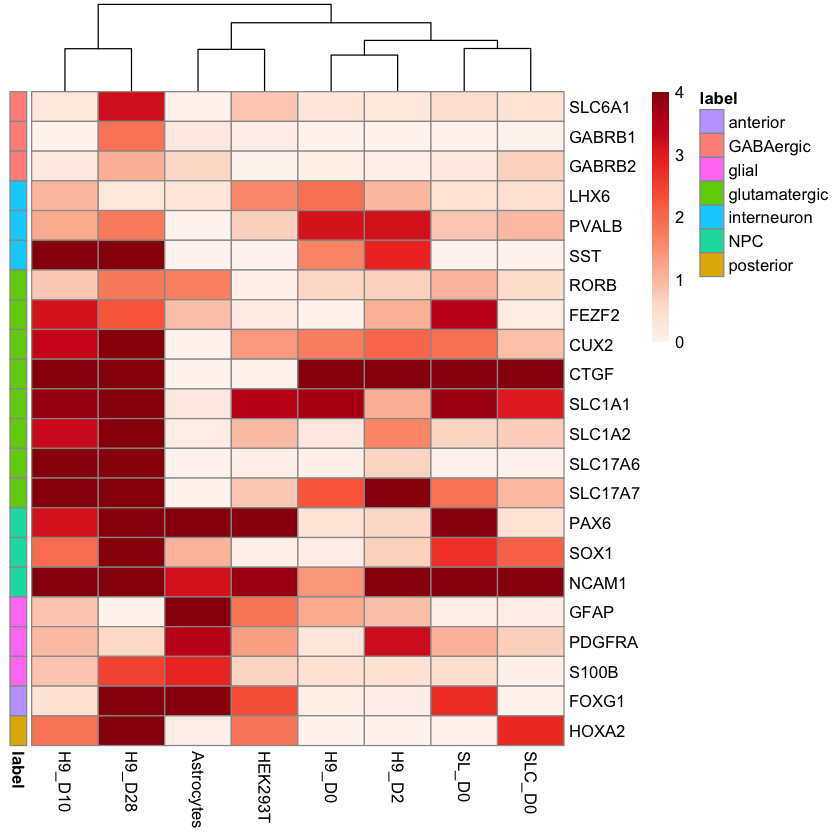

In [283]:
rna_df_sel = rna_df_tissue_log[marker_genes,tissues]
# rna_df_sel = rna_df_tissue[marker_genes,]
rna_df_sel[rna_df_sel>4] = 4
# rna_df_sel[rna_df_sel< -1] = -1
rna_df_sel
p = pheatmap(rna_df_sel,
            cluster_rows=F,  
             annotation_row=gene_markers_annon,
         color = colorRampPalette(brewer.pal(n =8, name ="Reds"))(255))
#          color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

save_pheatmap_pdf(p,paste0(save_prefix,'rna_marker_genes_expr_heatmap.pdf'))

Notes
- a little confusing, GAD1 is an inhibitory neuron marker which is lowly expressed in a of tissues
- so is ADARB2 and LAMP5
- SST is an interneuron marker which is very strongly on in the differentiated (time points)
- SLC17A7 is an excitatory neural marker which is on in the H9 days which is good
- THEMIS is probably just not mapped properly
- CTGF is very strongly expressed even in H9 D0... so it's probably an H9 marker
- AQP4 should be expressed in Astrocyes but it's not and PDGFRA is an oligodendrocyte marker

In [284]:
rna_df_log_with_brainmap_cat_t = cbind(rna_df_log_with_brainmap_t,metadata_all[,c("cluster_label",'class_label')])%>%
    group_by(class_label)%>%
    dplyr::select(-cluster_label)%>%
    summarise_all(mean)%>%
    column_to_rownames('class_label')

ERROR: Error in eval(quote(list(...)), env): object 'rna_df_log_with_brainmap_t' not found


In [194]:
# metadata_sel = data.frame(cell_type = as.character(unique(metadata$cat)),#%>% group_by(cat)
# cat = c(rep(c('our cell types'),times=10),rep(c('scRNA'),times=8)))%>%
#     column_to_rownames('cell_type')

In [195]:
# marker_genes = c('GAD1','ADARB2','LAMP5', 'PAX6','VIP','LHX6','SST','PVALB','SLC17A7',
# 'CUX2','RORB','THEMIS','FEZF2','CTGF','AQP4','PDGFRA','MOG','CLDN5','MUSTN1','FYB')
marker_genes = c('GAD1','ADARB2','LAMP5', 'PAX6','LHX6','VIP','SST','PVALB','SLC17A7',
 'CUX2','RORB','FEZF2','THEMIS','CTGF', 'MOG','CLDN5','MUSTN1',"GFAP", 'S100B', 'PDGFRA','FYB')

marker_genes_sel = marker_genes[marker_genes%in%colnames(rna_df_log_with_brainmap_t)]

ERROR: Error in colnames(rna_df_log_with_brainmap_t): object 'rna_df_log_with_brainmap_t' not found


In [196]:
sel_tissues = c('Astro',
'Astrocytes','Exc','H9_D0','H9_D10','H9_D2','H9_D28','HEK293T','Inh',#'Micro',
               'SL_D0','SLC_D0')

In [197]:
p = pheatmap(t(rna_df_log_with_brainmap_cat_t[sel_tissues,marker_genes_sel]),annotation_col=metadata_sel)
save_pheatmap_pdf(p, paste0(save_prefix,'expr_markers_sel_heatmap.pdf'),width=15,height=7)
pdf(paste0(save_prefix,'expr_markers_sel_dend.pdf'),width=,height=7)
par(bg='white')
plot(p$tree_col)
dev.off()

ERROR: Error in t(rna_df_log_with_brainmap_cat_t[sel_tissues, marker_genes_sel]): object 'rna_df_log_with_brainmap_cat_t' not found


Notes: 
- pretty good, the higher days of H9D10, H9D28  aren't like the others , astroand heks are closest to the astro/nonneuronal conditions, 
- inhibitory stuff is by itself
- excitatory phenotype is most close to the H9D2 condition

### try dimensionally reduction (dont use)

In [ ]:
# pca_res_sel <- prcomp(rna_df_log_with_brainmap_t[,marker_genes_sel], center=TRUE, scale = TRUE)

pca_res_sel <- prcomp(rna_df_log_with_brainmap_cat_t[,marker_genes_sel], center=TRUE, scale = TRUE)


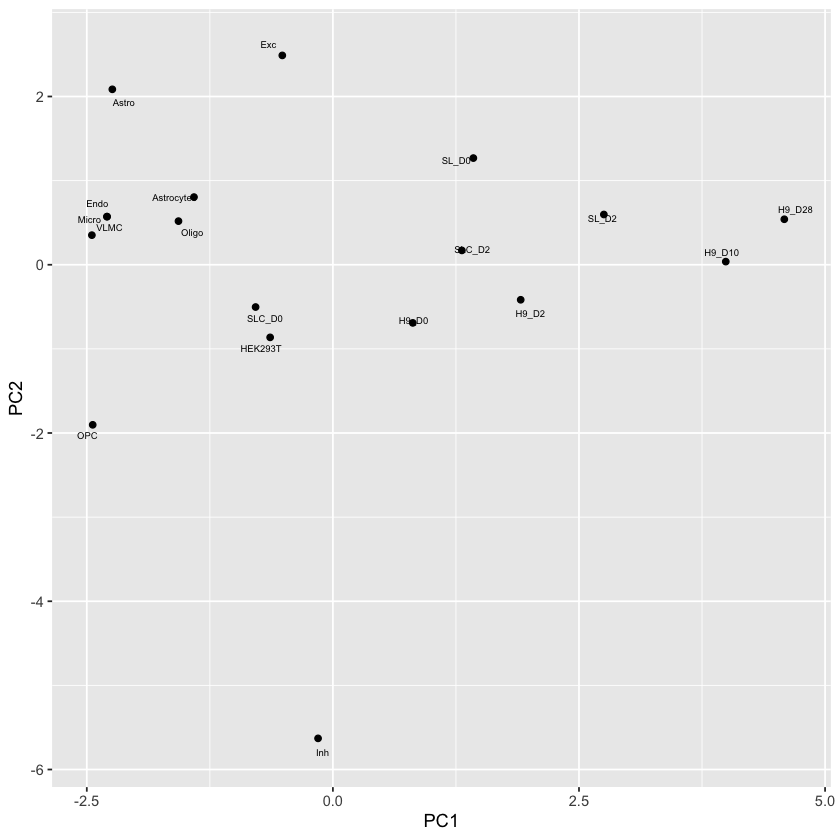

In [72]:
# autoplot(pca_res, data = brainspan_expr_gene_meta, colour = 'structure_acronym')
# ggplot(cbind(pca_res_sel$x, metadata), aes(x=PC1, y=PC2, color=cat,label=cell_type))+
#     geom_point()+
#   geom_text(size=2,position=position_jitter(width=5,height=5))

ggplot(data.frame(pca_res_sel$x) %>%rownames_to_column(), aes(x=PC1, y=PC2, label=rowname))+
    geom_point() + geom_text(size=2,position=position_jitter(width=.2,height=.2))
#+geom_text()

pdf 
  2

pdf 
  2

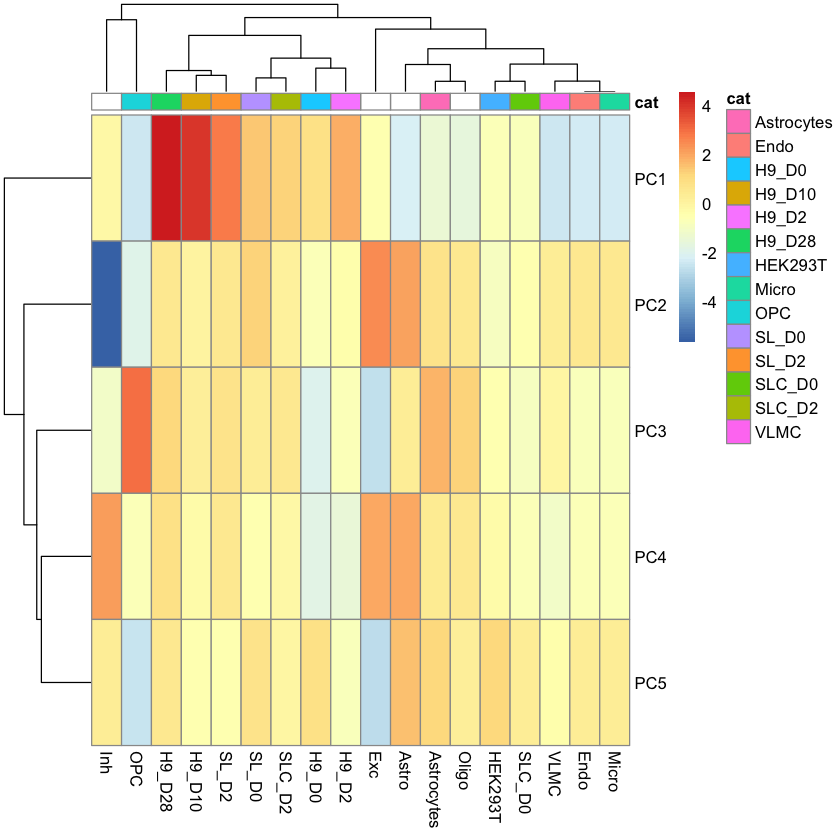

In [78]:
# p = pheatmap(t(pca_res_sel$x[,1:10]),annotation_col=dplyr::select(metadata,cat))
# save_pheatmap_pdf(p, paste0(save_prefix,'pca_markers_sel_heatmap.pdf'),width=15,height=7)
# pdf(paste0(save_prefix,'pca_markers_sel_dend.pdf'),width=,height=7)
# par(bg='white')
# plot(p$tree_col)
# dev.off()

p = pheatmap(t(pca_res_sel$x[,1:5]),annotation_col=dplyr::select(metadata,cat))
save_pheatmap_pdf(p, paste0(save_prefix,'pca_markers_sel_heatmap.pdf'),width=15,height=7)
pdf(paste0(save_prefix,'pca_markers_sel_dend.pdf'),width=,height=7)
par(bg='white')
plot(p$tree_col)
dev.off()

doesn't look good... 
excitatory neurons are not close to the H9 neural system

In [152]:
rna_df_tissue_sel = rna_df_tissue[rownames(rna_df_tissue) %in% colnames(brainspan_expr_gene_t),]



dim(rna_df_tissue_sel)

[1] 18469     9

#### only rna_df prcomp

In [235]:
pca_rna = prcomp(t(rna_df_tissue_sel), scale=TRUE, center=TRUE)

ERROR: Error in prcomp.default(t(rna_df_tissue_sel), scale = TRUE, center = TRUE): cannot rescale a constant/zero column to unit variance


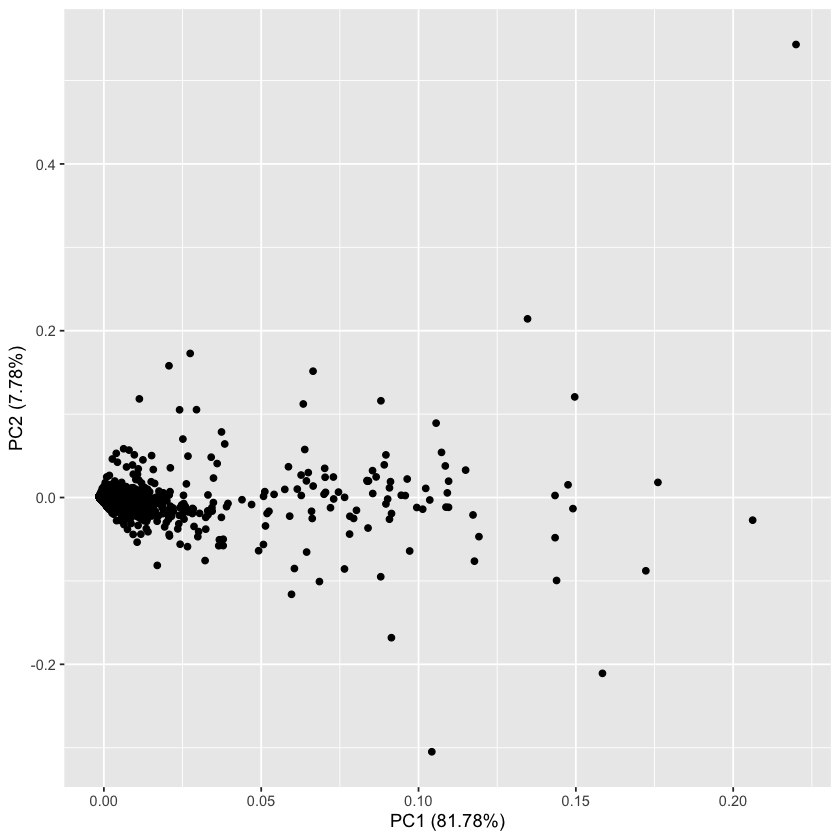

In [232]:
autoplot(pca_rna, data = rna_df_tissue_sel)

In [129]:
brainspan_sample_meta_structure$source = 'brainspan'

In [176]:
# colnames(brainspan_sample_meta_structure)

In [177]:
# colnames(meta_rna)

In [171]:
brainspan_expr_gene_t_tissue = cbind(brainspan_expr_gene_t, dplyr::select(brainspan_sample_meta_structure, structure_acronym))%>%
    group_by(structure_acronym)%>%
    summarise_each(mean)
    

In [173]:
write.csv(brainspan_expr_gene_t_tissue, paste0(save_prefix, 'brainspan_expr_gene_t_tissue.csv'))

In [174]:
brainspan_expr_gene_t_tissue = column_to_rownames(brainspan_expr_gene_t_tissue, "structure_acronym")
head(brainspan_expr_gene_t_tissue)

,A1BG,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,AACSP1,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1C,2.0730041,0.007017806,30.275905,0.34215697,0.07488152,1.0997817,0.01962203,6.358766,4.118813,0.06310452,⋯,5.787505,1.420416,1.560443,3.619885,2.521497,0.02455281,17.12007,20.61382,4.238008,3.968206
AMY,2.3337408,0.008834667,30.576676,0.49606385,0.08455179,1.1918605,0.03074212,8.184450,3.180154,0.03163721,⋯,6.752544,6.448841,1.463237,3.375435,2.998116,0.03811509,14.29830,18.07738,4.093876,4.729322
CB,0.5463363,0.004733667,8.914792,0.08099967,0.02137767,1.1690703,0.00000000,10.219521,2.284872,0.02538467,⋯,12.392888,6.790210,2.374688,4.086244,4.272903,0.05795967,18.77170,33.86956,5.896607,5.171324
CBC,3.0679737,0.009572552,28.010295,0.10785448,0.07228107,1.3368455,0.01834093,8.713176,1.501258,0.05883810,⋯,4.929176,3.225485,1.283196,3.457040,3.293390,0.10647845,15.64588,36.60498,5.696269,3.294823
CGE,0.7225695,0.000000000,8.709259,0.05313500,0.03194500,0.3825850,0.00000000,20.703646,3.566759,0.00619550,⋯,15.404613,37.305183,2.036205,4.849229,5.668076,0.02927600,16.58821,28.63526,4.949292,7.613434
DFC,2.4825083,0.026394143,26.533456,0.27862466,0.05157217,0.8678225,0.02497377,7.039464,4.253710,0.05669574,⋯,6.019348,3.523183,1.425775,3.250983,2.598355,0.01775011,16.92452,19.74215,3.959177,3.860113


In [193]:
# meta_rna = data.frame(donor_id	= 1:length(colnames(rna_df_tissue_sel)), donor_name='none', age = 'none', gender='none',
#         structure_id= 1:length(colnames(rna_df_tissue_sel)), structure_acronym = colnames(rna_df_tissue_sel),	structure_name = colnames(rna_df_tissue_sel),
#                      source='inhouse')	

# meta_rna = rbind(brainspan_sample_meta_structure, meta_rna)


meta_brainspan_tissue = data.frame(tissue=rownames(brainspan_expr_gene_t_tissue), source='brainspan')
meta_rna = data.frame(tissue=colnames(rna_df_tissue_sel),source='inhouse')
meta_rna = rbind(meta_brainspan_tissue, meta_rna)
rownames(meta_rna) = meta_rna$tissue

In [179]:
# data_rna = rbind(brainspan_expr_gene_t,t(rna_df_tissue_sel))
data_rna = rbind(brainspan_expr_gene_t_tissue,t(rna_df_tissue_sel))

data_rna_norm = t(apply(data_rna, 1, function(x)(x-min(x))/(max(x)-min(x))))


In [180]:
pca_res <- prcomp(data_rna_norm, center=TRUE, scale = TRUE)


In [181]:
summary(pca_res)

Importance of components:
                           PC1     PC2      PC3      PC4      PC5     PC6
Standard deviation     93.8189 53.9624 38.16226 30.35088 27.29753 22.3322
Proportion of Variance  0.4766  0.1577  0.07885  0.04988  0.04035  0.0270
Cumulative Proportion   0.4766  0.6342  0.71310  0.76298  0.80333  0.8303
                           PC7     PC8      PC9     PC10     PC11     PC12
Standard deviation     21.5292 18.5340 17.30828 16.12169 15.66339 14.03761
Proportion of Variance  0.0251  0.0186  0.01622  0.01407  0.01328  0.01067
Cumulative Proportion   0.8554  0.8740  0.89025  0.90432  0.91760  0.92827
                           PC13    PC14     PC15     PC16    PC17    PC18
Standard deviation     13.05146 12.3847 10.64970 10.23544 9.90932 9.25481
Proportion of Variance  0.00922  0.0083  0.00614  0.00567 0.00532 0.00464
Cumulative Proportion   0.93749  0.9458  0.95194  0.95761 0.96293 0.96757
                          PC19    PC20    PC21    PC22    PC23    PC24   PC25
Stan

first 50 comp are 0.86760 explained variance

[1] ""

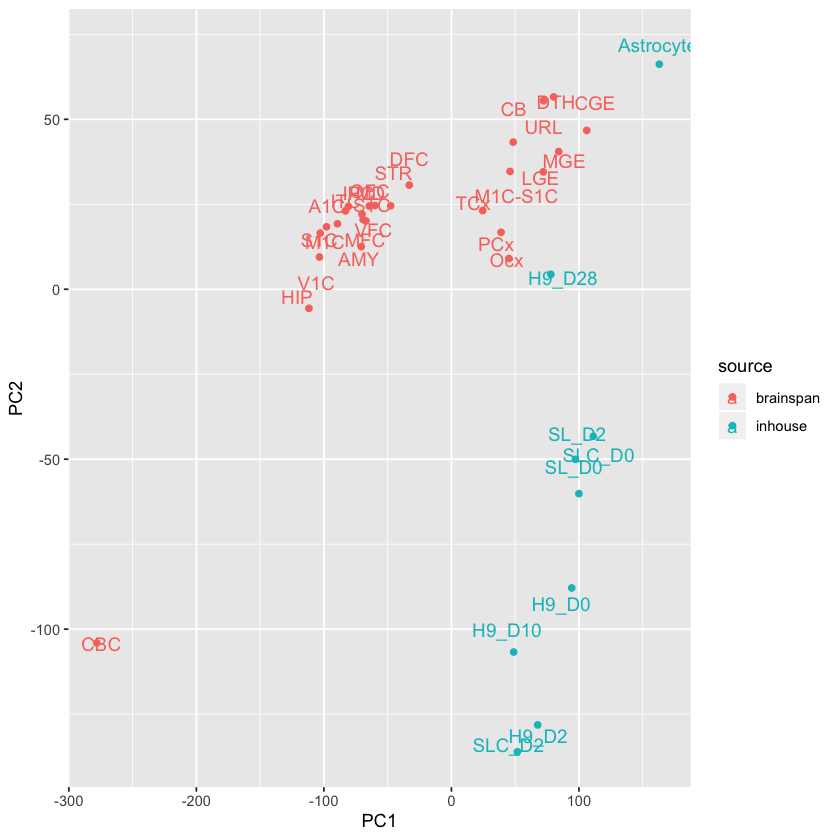

In [200]:
# autoplot(pca_res, data = brainspan_expr_gene_meta, colour = 'structure_acronym')
ggplot(cbind(pca_res$x, meta_rna), aes(x=PC1, y=PC2, color=source,label=tissue))+
    geom_point()+
  geom_text(size=4,position=position_jitter(width=10,height=10))
''#+geom_text()

In [164]:
tsne_results <- Rtsne(pca_res$x, perplexity=10, check_duplicates = FALSE)

In [214]:
tsne_plot_df = data.frame(tsne_results$Y)
rownames(tsne_plot_df) = rownames(pca_res$x)
tsne_plot_df$tissue =  rownames(pca_res$x)

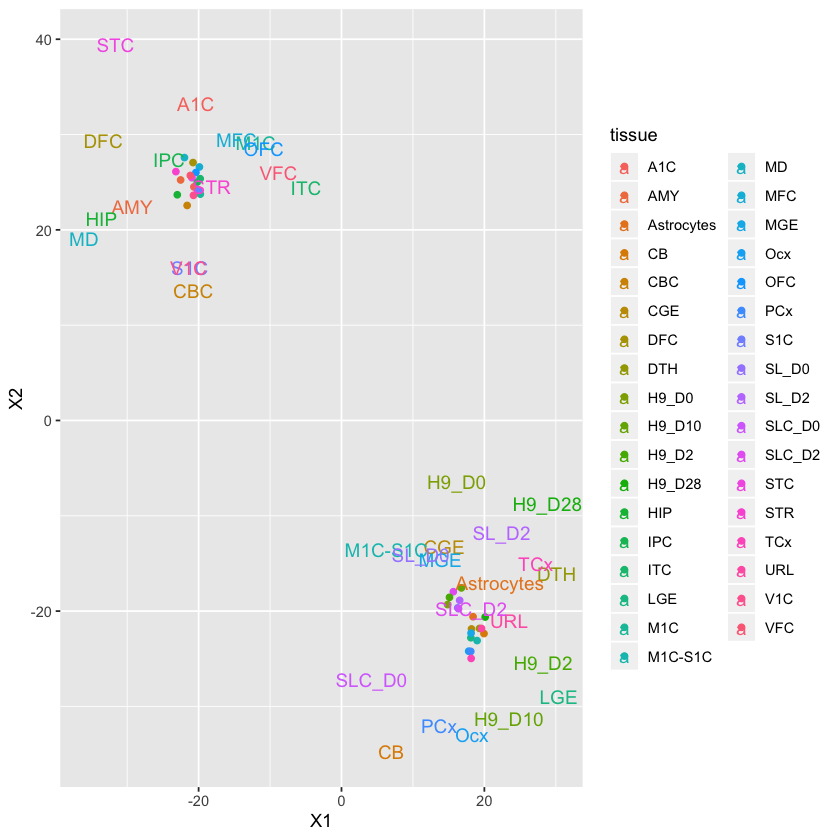

In [220]:
ggplot(tsne_plot_df,aes(x=X1,y=X2,color=tissue,label=tissue))+
    geom_point()+
  geom_text(size=4,position=position_jitter(width=15,height=15))
ggsave(paste0(save_prefix,'tsne_tissues.pdf'),width=8,height=8)

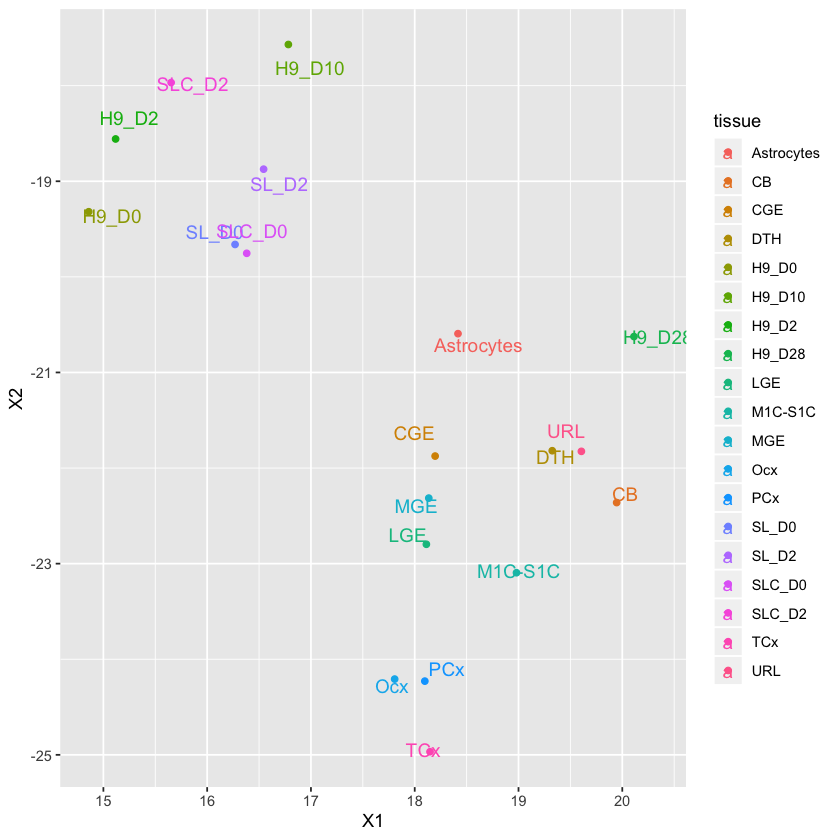

In [227]:
ggplot(filter(tsne_plot_df, (X1>0) & (X2<0)),aes(x=X1,y=X2,color=tissue,label=tissue))+
    geom_point()+
  geom_text(size=4,position=position_jitter(width=.25,height=.25))
ggsave(paste0(save_prefix,'tsne_tissues_filt.pdf'),width=8,height=8)

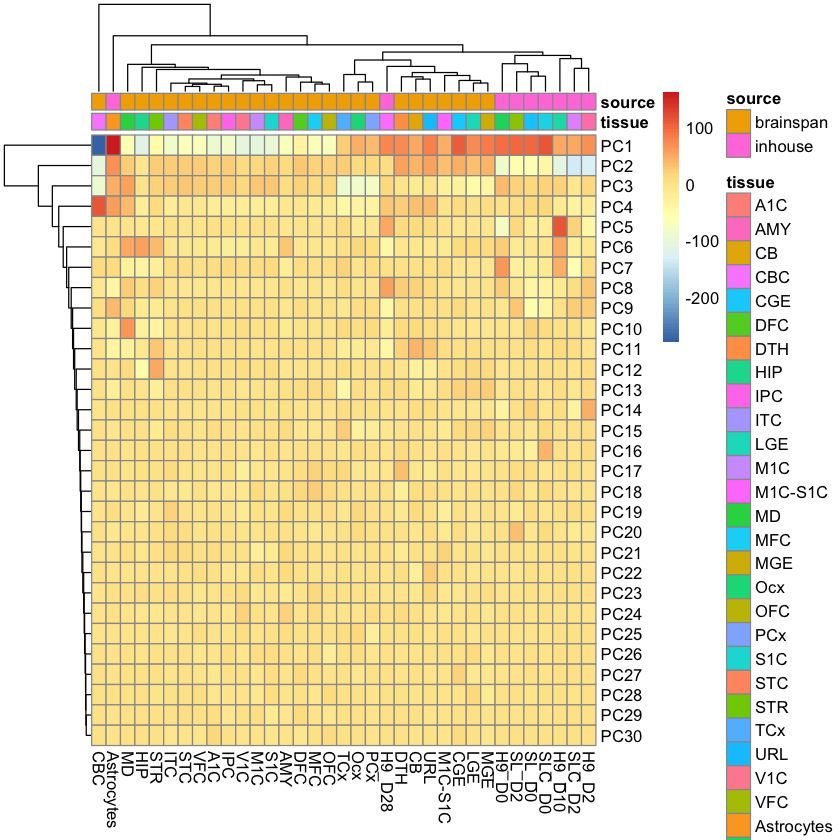

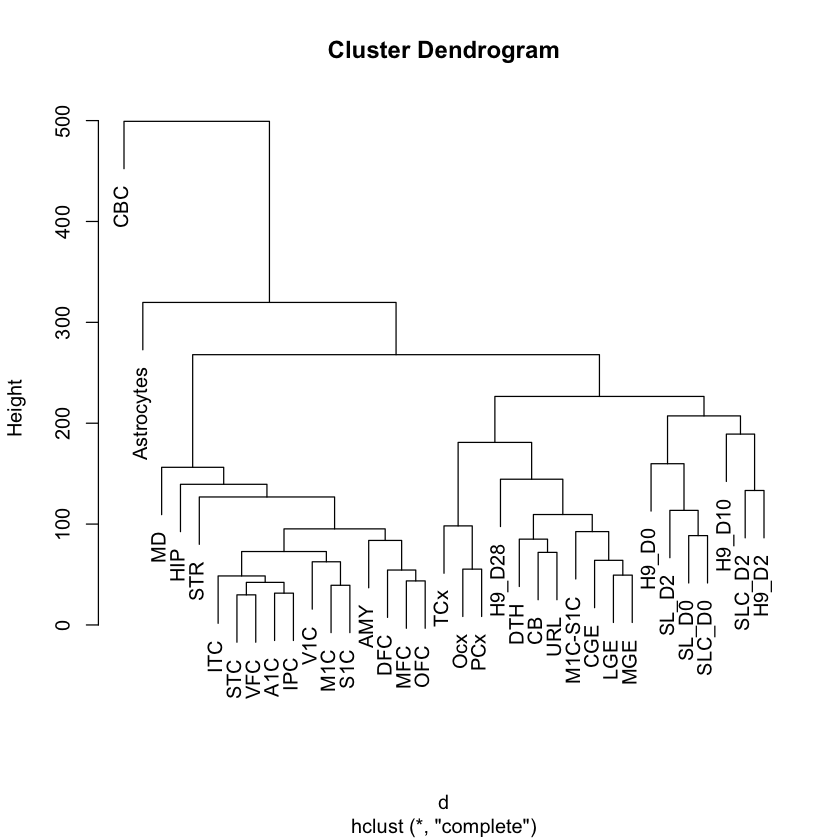

In [198]:
p = pheatmap(t(pca_res$x[,1:30]),annotation_col=meta_rna)
par(bg='white')
plot(p$tree_col)

In [199]:
acr_to_name

structure_acronym,structure_name
<fct>,<fct>
A1C,primary auditory cortex (core)
AMY,amygdaloid complex
CB,cerebellum
CBC,cerebellar cortex
CGE,caudal ganglionic eminence
DFC,dorsolateral prefrontal cortex
DTH,dorsal thalamus
HIP,hippocampus (hippocampal formation)
IPC,posteroventral (inferior) parietal cortex


# _. get egene data

In [102]:
diseases = c('all','schizo','depress','bipolar','anxiety','attent','personality','panic','traum','autism','ocd')
egene_dir = '/Users/mguo123/Google Drive/1_khavari/noncancer_project/miseq/novogene_071420/D_mpraanalyze_barcode_allelic/egene_gtex/'

In [105]:
read_genes = function(dz){
    print(dz)
    genes = read.csv(paste0(egene_dir,dz,'.txt'),header=F,stringsAsFactor=F)$V1
    print(length(genes))
    return(genes)
    
}
# get_expr

In [106]:
dim(brainmap_expr_df_region)

[1]     8 50281

[1]   8 416
[1]   8 115


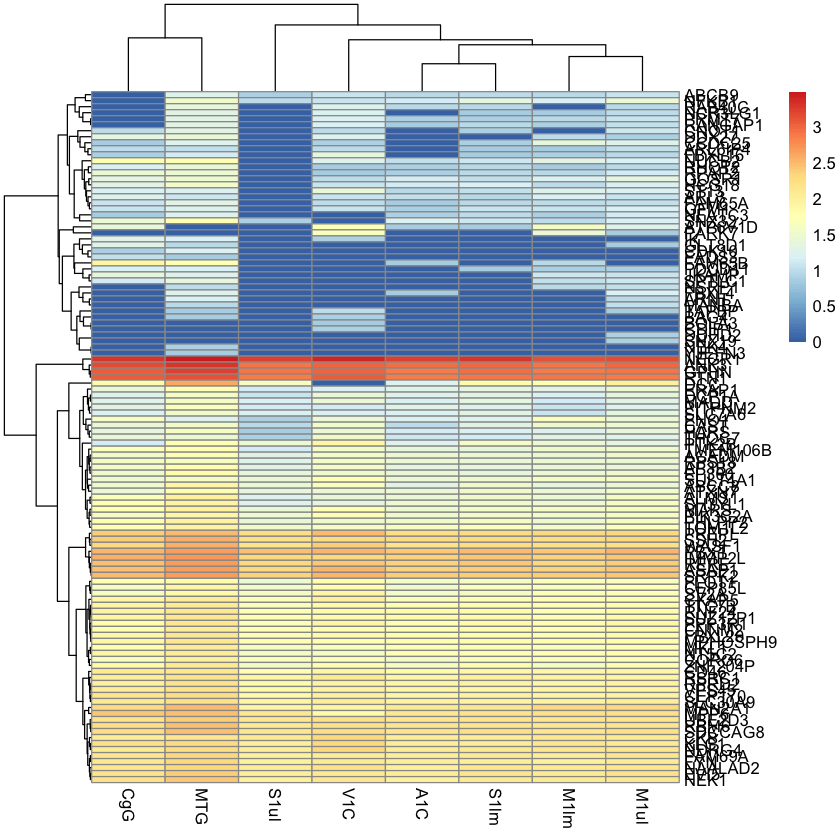

In [108]:
region_gene_df = brainmap_expr_df_region[,dz_genes$all[dz_genes$all%in% colnames(brainmap_expr_df_region)]]
region_gene_df[region_gene_df<=5] = 0
pheatmap(log10(t(remove_lowvar_genes(region_gene_df))+1))

In [111]:
'CHRNA2'%in% colnames(brainmap_expr_df_region)

[1] TRUE

In [114]:
log10(t(remove_lowvar_genes(region_gene_df))+1)#[,'CHRNA2']

[1]   8 416
[1]   8 115


,A1C,CgG,M1lm,M1ul,MTG,S1lm,S1ul,V1C
ABCB9,0.9542425,0.000000,0.9542425,1.0791812,1.255273,1.0000000,0.9030900,1.079181
ABCC8,1.3222193,1.518514,1.3617278,1.4623980,1.886491,1.5314789,1.4471580,1.662758
ACADM,1.4623980,1.568202,1.4471580,1.5118834,1.724276,1.4623980,1.3222193,1.544068
ALMS1,1.3979400,1.662758,1.4623980,1.6020600,1.977724,1.5051500,1.2552725,1.414973
ANK3,2.9595184,3.148911,2.9247960,2.9840770,3.299725,2.9745117,2.9159272,3.028978
AP3B2,1.3424227,1.568202,1.3979400,1.3979400,1.806180,1.3802112,1.2787536,1.556303
ARL3,1.0413927,1.230449,1.1760913,1.0791812,1.113943,0.9542425,0.0000000,1.079181
ARL6IP4,0.0000000,1.000000,0.8450980,1.0413927,1.041393,0.8450980,0.0000000,1.000000
ARNT,0.0000000,0.000000,0.0000000,0.9542425,1.176091,0.0000000,0.0000000,0.000000
ASAP1,2.3579348,2.474216,2.3636120,2.4232459,2.664642,2.3891661,2.3263359,2.539076


In [107]:
dz_genes = sapply(diseases, read_genes)

[1] "all"
[1] 429
[1] "schizo"
[1] 308
[1] "depress"
[1] 55
[1] "bipolar"
[1] 129
[1] "anxiety"
[1] 18
[1] "attent"
[1] 46
[1] "personality"
[1] 12
[1] "panic"
[1] 4
[1] "traum"
[1] 5
[1] "autism"
[1] 1
[1] "ocd"
[1] 20
